# Preprocessing audio files to create our dataset

In [2]:
import os #file handling
import pandas as pd #data handling
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm #progress bar

#audio processing
import librosa
import librosa.display

#to play audio
import IPython.display as ipd

#remove warnings
import warnings
warnings.filterwarnings('ignore')

#to save computer expensive variables
import pickle

In [3]:
path = "VoxCeleb_gender"

In [4]:
files = os.listdir(path)
folders = [f for f in files if os.path.isdir(os.path.join(path, f))]
print(folders)

['females', 'males']


In [5]:
# Count audios
audios_count = 0
males_count = 0
females_count = 0
for folder in folders:
    files = os.listdir(os.path.join(path, folder))
    for file in files:
        if file.endswith(".m4a"):
            with open(os.path.join(path, folder, file), 'r') as f:
                if folder.startswith("m"):
                    males_count += 1
                elif folder.startswith("f"):
                    females_count += 1
                audios_count += 1

print(f"Mans audios: {males_count} ({round(males_count/audios_count*100,2)}%)")
print(f"Womans audios: {females_count} ({round(females_count/audios_count*100,2)}%)")
print(f"Total audios: {audios_count}")


Mans audios: 3682 (61.44%)
Womans audios: 2311 (38.56%)
Total audios: 5993


In [6]:
#load audio
def load_audio(file_path):
    audio, sr = librosa.load(file_path)
    return audio, sr

In [7]:
audio_test, sr_test = load_audio(path + "/males/1.m4a")

In [8]:
def plot_waveform(audio, sr, title="Waveform"):
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(audio, sr=sr)
    plt.title(title)
    plt.show()

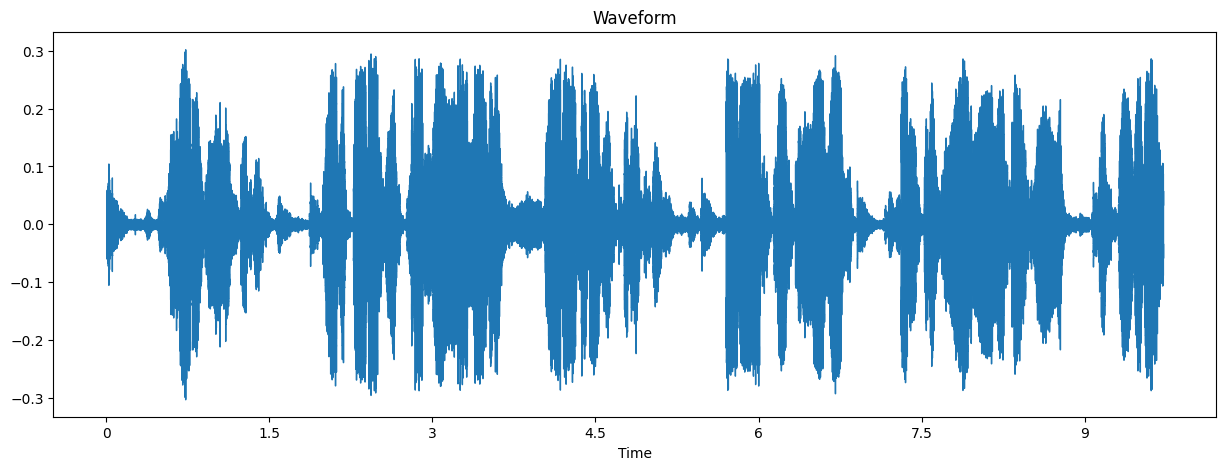

In [9]:
plot_waveform(audio_test, sr_test)

In [10]:
# audio spectogram
def plot_spectrogram(x, sr, y_axis= 'hz',title="Spectrogram"):
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis=y_axis)
    plt.colorbar()


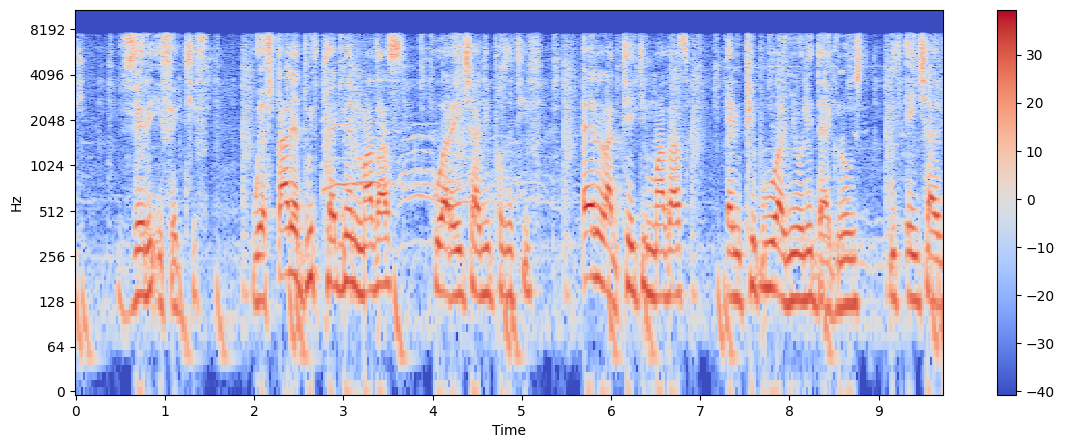

In [10]:
plot_spectrogram(audio_test, sr_test, 'log')

# Features extraction

## Key Audio Features for Gender Classification

1. **Mel-Frequency Cepstral Coefficients (MFCC)**
   - **Purpose**: Captures the timbral properties of the voice, which can differ significantly between male and female speakers.
   - **Usage**: Widely used in speech recognition tasks due to their effectiveness in representing vocal characteristics.
   - **Example Feature**: `librosa.feature.mfcc`

2. **Spectral Centroid**
   - **Purpose**: Represents the "center of mass" of the spectrum, which indicates where most of the frequency energy is concentrated.
   - **Relevance**: Typically, female voices have a higher spectral centroid due to the presence of higher frequencies.
   - **Example Feature**: `librosa.feature.spectral_centroid`

3. **Spectral Bandwidth**
   - **Purpose**: Measures the width of the spectrum, representing the range of frequencies that contribute to the sound.
   - **Relevance**: Helps in distinguishing between the spread of frequency components in male and female voices.
   - **Example Feature**: `librosa.feature.spectral_bandwidth`

4. **Zero Crossing Rate**
   - **Purpose**: Measures the rate at which the signal changes sign, which can indicate the presence of high-frequency content.
   - **Relevance**: Female voices, with typically higher pitch, often show a higher zero crossing rate.
   - **Example Feature**: `librosa.feature.zero_crossing_rate`

5. **Root Mean Square (RMS) Energy**
   - **Purpose**: Represents the power of the signal, providing an idea of the loudness of the voice.
   - **Relevance**: Can differentiate between more "powerful" male voices and typically softer female voices.
   - **Example Feature**: `librosa.feature.rms`

6. **Spectral Rolloff**
   - **Purpose**: Determines the frequency below which a specified percentage (typically 85%) of the total spectral energy is contained.
   - **Relevance**: Useful for identifying the cutoff point of frequency components, which can vary between male and female voices.
   - **Example Feature**: `librosa.feature.spectral_rolloff`

7. **Delta and Delta-Delta MFCCs**
   - **Purpose**: Capture the temporal dynamics of the MFCC features, representing how these coefficients change over time.
   - **Relevance**: Provides insights into the vocal inflections and transitions, which can differ across genders.
   - **Example Feature**: `librosa.feature.delta`


In [85]:
def extract_features(y,sr):    
    #Extract features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 coefficients MFCC
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
    rms = librosa.feature.rms(y=y)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    #Deltas of mfccs
    mfccs_delta = librosa.feature.delta(mfccs)
    mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

    #Stacking features into one 44-sized
    features = np.hstack([
        #We mean every features to get only one value representing the audio
        np.mean(mfccs, axis=1), #13
        np.mean(mfccs_delta, axis=1), #13
        np.mean(mfccs_delta2, axis=1), #13
        np.mean(spectral_centroid), #1
        np.mean(spectral_bandwidth), #1
        np.mean(zero_crossing_rate), #1
        np.mean(rms), #1
        np.mean(spectral_rolloff) #1
    ]) # = 44 features
    return features

In [82]:
features = extract_features(audio_test, sr_test)

In [83]:
features.shape

(13,)

In [84]:
features

array([-2.4926208e+02,  9.7914513e+01, -2.0877403e+01,  5.8879150e+01,
       -3.6129566e+01,  3.2417828e+01, -3.2753525e+01,  1.3661249e+01,
       -1.4511730e+01, -6.3640267e-01, -2.1747647e-01, -8.3767900e+00,
        5.7053242e+00], dtype=float32)

In [93]:
def createAverageDataset(path):
    files = os.listdir(path)
    folders = [f for f in files if os.path.isdir(os.path.join(path, f))]
    data = []
    pbar = tqdm(total = audios_count ) # progress bar    
    for folder in folders:
        files = os.listdir(os.path.join(path, folder))
        for file in files:
            if file.endswith(".m4a"):
                with open(os.path.join(path, folder, file), 'r') as f:
                    audio, sr = load_audio(path+"/"+folder+"/"+file)
                    features = extract_features(audio, sr)
                    data.append({
                        'gender' : folder[0],
                        'mfcc_feature_1' : features[0],
                        'mfcc_feature_2' : features[1],
                        'mfcc_feature_3' : features[2],
                        'mfcc_feature_4' : features[3],
                        'mfcc_feature_5' : features[4],
                        'mfcc_feature_6' : features[5],
                        'mfcc_feature_7' : features[6],
                        'mfcc_feature_8' : features[7],
                        'mfcc_feature_9' : features[8],
                        'mfcc_feature_10' : features[9],
                        'mfcc_feature_11' : features[10],
                        'mfcc_feature_12' : features[11],
                        'mfcc_feature_13' : features[12],
                        'delta1_feature_1' : features[13],
                        'delta1_feature_2' : features[14],
                        'delta1_feature_3' : features[15],
                        'delta1_feature_4' : features[16],
                        'delta1_feature_5' : features[17],
                        'delta1_feature_6' : features[18],
                        'delta1_feature_7' : features[19],
                        'delta1_feature_8' : features[20],
                        'delta1_feature_9' : features[21],
                        'delta1_feature_10' : features[22],
                        'delta1_feature_11' : features[23],
                        'delta1_feature_12' : features[24],
                        'delta1_feature_13' : features[25],
                        'delta2_feature_1' : features[26],
                        'delta2_feature_2' : features[27],
                        'delta2_feature_3' : features[28],
                        'delta2_feature_4' : features[29],
                        'delta2_feature_5' : features[30],
                        'delta2_feature_6' : features[31],
                        'delta2_feature_7' : features[32],
                        'delta2_feature_8' : features[33],
                        'delta2_feature_9' : features[34],
                        'delta2_feature_10' : features[35],
                        'delta2_feature_11' : features[36],
                        'delta2_feature_12' : features[37],
                        'delta2_feature_13' : features[38],
                        'spectral_centroid' : features[39],
                        'spectral_bandwidth' : features[40],
                        'zero_crossing_rate' : features[41],
                        'rms' : features[42],
                        'spectral_rolloff' : features[43],
                    })
                    pbar.update(1)
    pbar.close()
    return pd.DataFrame(data)

In [94]:
averageDataset = createAverageDataset(path)

In [95]:
averageDataset

,gender,mfcc_feature_1,mfcc_feature_2,mfcc_feature_3,mfcc_feature_4,mfcc_feature_5,mfcc_feature_6,mfcc_feature_7,mfcc_feature_8,mfcc_feature_9,...,delta2_feature_9,delta2_feature_10,delta2_feature_11,delta2_feature_12,delta2_feature_13,spectral_centroid,spectral_bandwidth,zero_crossing_rate,rms,spectral_rolloff
0,f,-261.329376,128.835617,-46.803890,34.379749,-33.132378,17.100742,-41.055466,6.149195,-24.271091,...,-0.056852,-0.018926,-0.062693,0.027363,0.043593,1893.759877,1844.429856,0.092675,0.043256,3829.661063
1,f,-360.135529,134.216812,-46.357185,30.270189,-7.256501,-12.362634,-17.299755,-3.161893,-3.762040,...,-0.004211,-0.015071,0.020860,-0.004695,-0.009887,1606.318761,1427.986776,0.097212,0.024582,2996.981693
2,f,-286.690765,156.186584,-41.509094,31.947565,-10.560344,-19.950380,-10.129725,-3.674345,-21.549614,...,0.013978,0.030787,-0.059828,-0.005424,0.034735,1471.610775,1401.235810,0.084658,0.045490,2883.150101
3,f,-299.983948,116.739891,-67.227562,46.645077,-34.803585,22.505936,-23.869476,5.576423,-3.070676,...,0.013208,-0.003000,0.003672,-0.002365,-0.026001,2289.833360,1745.082359,0.152470,0.024640,4266.686085
4,f,-294.242188,125.607529,-12.183384,27.121918,-21.402309,19.211809,-37.409805,4.842865,-13.371928,...,0.009805,0.025247,-0.045269,-0.004989,0.011084,2018.222078,1702.813100,0.141774,0.054737,3559.760325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988,m,-126.744102,140.250870,-83.678558,20.616764,-25.494482,-4.816887,-35.334602,-17.951571,-33.505730,...,0.062034,-0.006147,0.045306,0.054977,0.044058,1698.533677,1340.849404,0.109503,0.149627,2963.592080
5989,m,-326.324402,147.580124,-11.765425,41.411476,-19.821945,2.909330,-24.478537,0.469839,-13.231600,...,-0.008805,0.026185,-0.039336,0.027020,0.067597,1338.227226,1375.068740,0.078851,0.046982,2431.839940
5990,m,-223.164627,160.098129,-12.670789,46.775211,-4.868187,9.461629,-7.377435,-2.501803,-9.316516,...,0.115600,0.000100,-0.021295,-0.024490,0.001369,1173.682304,1367.760517,0.056275,0.104549,2281.540749
5991,m,-412.057678,146.959000,-25.511068,43.604912,-15.084287,-5.401690,-13.202021,-3.270955,-15.048368,...,0.064946,0.037536,0.041298,0.012323,0.017743,1450.339631,1490.671229,0.079369,0.014216,2951.461640


In [96]:
averageDataset.to_csv("csv/averageDataset.csv", index=False)